# HSMA 6 - Session 4G - Exercise 2B 

## Core

We're going to work with a dataset to try to predict patient length of stay. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from xgboost import XGBRegressor
# import any other libraries you need
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, \
                            r2_score, root_mean_squared_error

# Additional imports for explainable AI
from sklearn.inspection import PartialDependenceDisplay, permutation_importance

# Import shap for shapley values
import shap

# JavaScript Important for the interactive charts later on
shap.initjs()

Run this cell to load in the dataframe containing the LOS data and view the dataframe.

In [3]:
los_df = pd.read_csv("../datasets/los_dataset/LengthOfStay.csv", index_col="eid")
los_df.head()

Run these cells to tidy the dataframe.

In [ ]:
# Remove the date column
los_df = los_df.drop(columns="vdate")
# Convert the gender column to 0/1 and rename
los_df['gender'].replace('M', 0, inplace=True)
los_df['gender'].replace('F', 1, inplace=True)
los_df.rename(columns={'female': 'gender'}, inplace=True)

# Convert the facilities to one hot encoding
# Bonus - astype('int') will convert the true/false values to 0/1
# not necessary - it will work regardless
one_hot = pd.get_dummies(los_df['facid']).astype('int')
los_df = los_df.drop('facid', axis=1)
los_df = los_df.join(one_hot)

# Convert the readmission count to one hot encoding
# Bonus - astype('int') will convert the true/false values to 0/1
# not necessary - it will work regardless
one_hot = pd.get_dummies(los_df['rcount'], prefix="rcount").astype('int')
los_df = los_df.drop('rcount', axis=1)
los_df = los_df.join(one_hot)
los_df.head()

,rcount,gender,dialysisrenalendstage,asthma,irondef,pneum,substancedependence,psychologicaldisordermajor,depress,psychother,...,sodium,glucose,bloodureanitro,creatinine,bmi,pulse,respiration,secondarydiagnosisnonicd9,facid,lengthofstay
eid,,,,,,,,,,,,,,,,,,,,,
1,0,F,0,0,0,0,0,0,0,0,...,140.361132,192.476918,12.0,1.390722,30.432418,96,6.5,4,B,3


Train an xgboost decision tree model to predict length of stay based on the variables in this dataset. 

In [12]:
X = los_df.drop(columns='lengthofstay')
y = los_df['lengthofstay']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size = 0.25,
    random_state=42
    )

regr_xgb = XGBRegressor(random_state=42)

# Train the model using the training sets
regr_xgb.fit(X_train, y_train)

# Make predictions using the testing set
y_pred_train = regr_xgb.predict(X_train)
y_pred_test = regr_xgb.predict(X_test)

Assess the performance of this model.

In [14]:
print("TRAINING DATA")
print(f"Mean absolute error: {mean_absolute_error(y_train, y_pred_train):.2f}")
print(f"Mean absolute percentage error: {mean_absolute_percentage_error(y_train, y_pred_train):.2%}" )
print("Root Mean squared error: %.2f" % root_mean_squared_error(y_train, y_pred_train))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_train, y_pred_train))

TRAINING DATA
Mean absolute error: 0.00
Mean absolute percentage error: 0.00%
Root Mean squared error: 0.00
Coefficient of determination: 1.00


In [15]:
print("TESTING DATA")
print(f"Mean absolute error: {mean_absolute_error(y_test, y_pred_test):.2f}")
print(f"Mean absolute percentage error: {mean_absolute_percentage_error(y_test, y_pred_test):.2%}" )
print("Root Mean squared error: %.2f" % root_mean_squared_error(y_test, y_pred_test))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred_test))

TESTING DATA
Mean absolute error: 0.50
Mean absolute percentage error: 12.94%
Root Mean squared error: 0.93
Coefficient of determination: 0.84


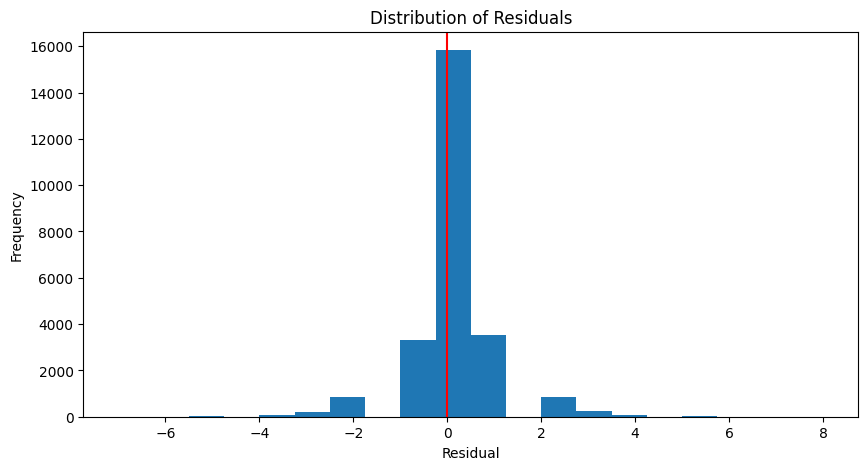

In [16]:
def plot_residuals(actual, predicted):
    residuals = actual - predicted

    plt.figure(figsize=(10, 5))
    plt.hist(residuals, bins=20)
    plt.axvline(x = 0, color = 'r')
    plt.xlabel('Residual')
    plt.ylabel('Frequency')
    plt.title('Distribution of Residuals')
    plt.show()

plot_residuals(y_test, y_pred_test)

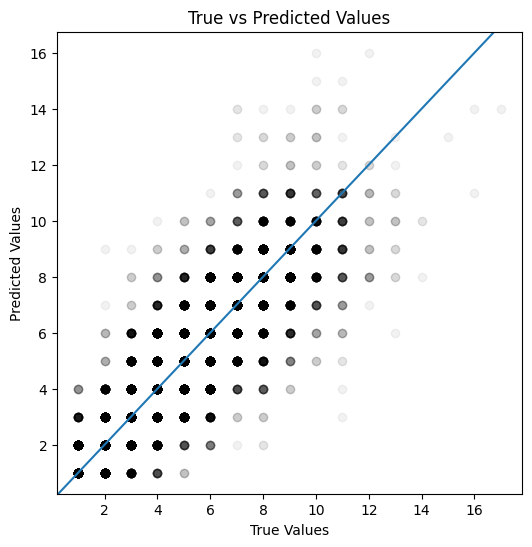

In [17]:
def plot_actual_vs_predicted(actual, predicted):
    fig, ax = plt.subplots(figsize=(6, 6))

    ax.scatter(actual, predicted, color="black", alpha=0.05)
    ax.axline((1, 1), slope=1)
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title('True vs Predicted Values')
    plt.show()

plot_actual_vs_predicted(y_test, y_pred_test)

## Explainable AI

### Explore feature importance

#### Importance with MDI

,importance_xgb,rank_xgb
rcount_0,0.298638,1.0
rcount_1,0.223313,2.0
E,0.104948,3.0
rcount_2,0.095113,4.0
rcount_3,0.044833,5.0


### Importance using PFI

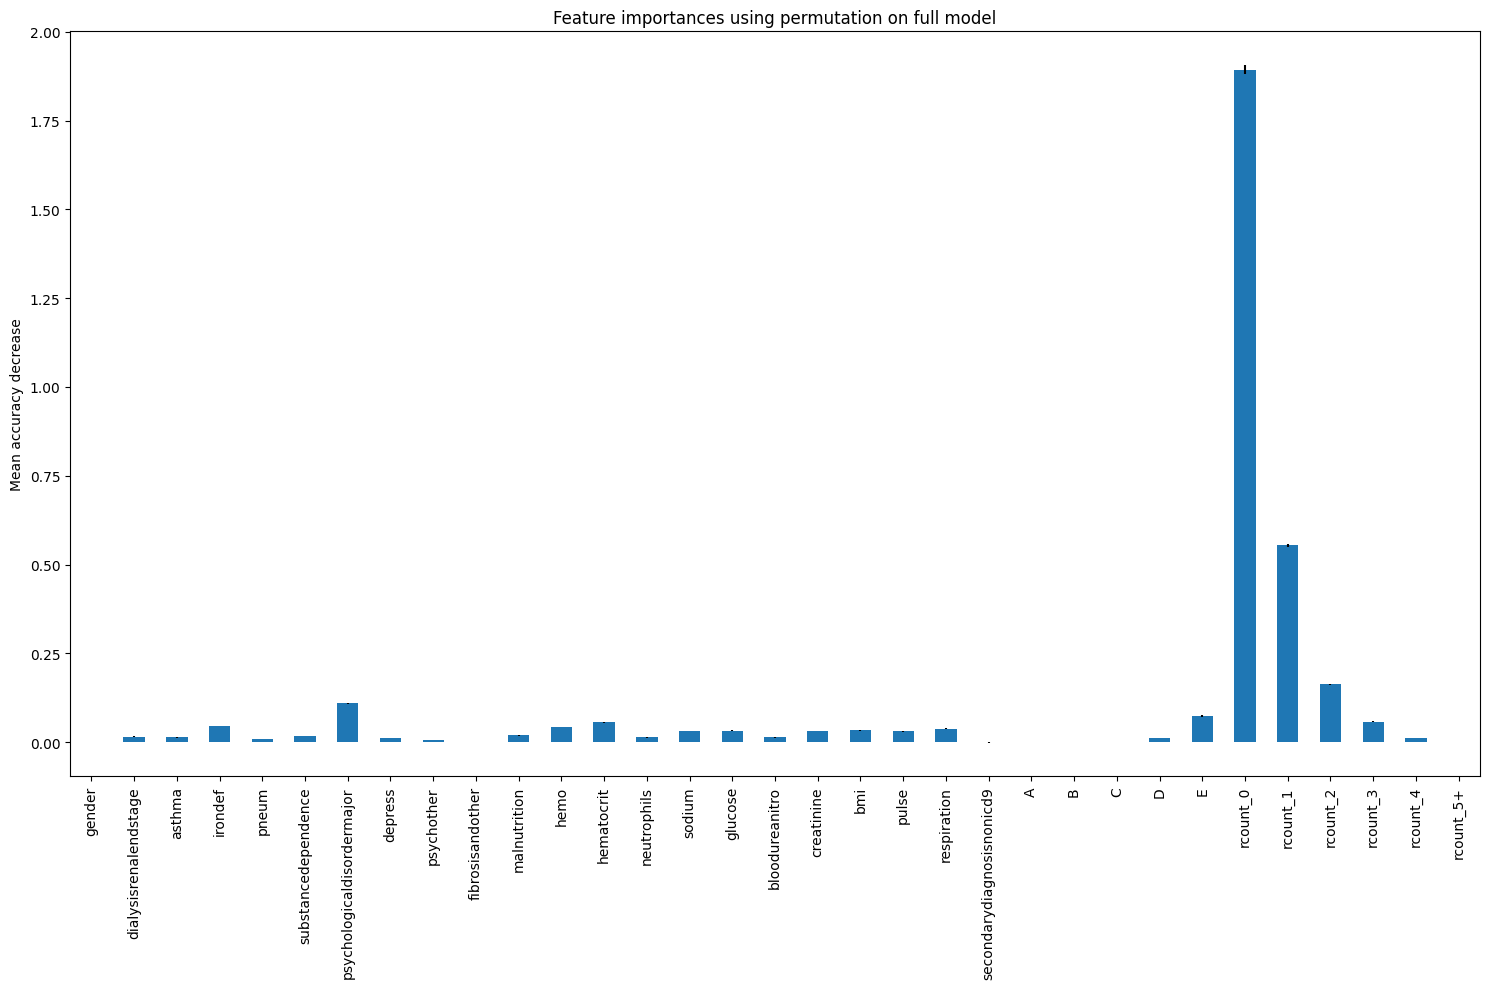

## SHAP

Create the SHAP explainer and the shap values.

.values =
array([[-2.6650396e-03, -2.8349245e-02, -2.8206887e-02, ...,
         3.6678225e-02, -1.1050860e-02, -4.2748421e-02],
       [-6.2315684e-04, -2.3170978e-02, -2.6661476e-02, ...,
         1.7028286e-01,  5.3098965e-02,  7.8511810e-01],
       [-2.1074347e-03, -2.4248261e-02, -3.0950839e-02, ...,
         5.2135639e-02, -6.1736503e-03, -5.5587869e-02],
       ...,
       [-6.5551219e-03, -4.1813911e-03, -1.5697110e-02, ...,
         5.0065227e-02, -9.1353338e-03, -5.7418041e-02],
       [ 8.7963063e-03, -1.7835531e-02, -3.2572955e-02, ...,
         4.4359848e-02, -1.0301362e-02, -3.7316192e-02],
       [-2.5621285e-03, -2.4446361e-02, -3.5786040e-02, ...,
         3.5279468e-02, -1.6822470e-02, -4.6163432e-02]], dtype=float32)

.base_values =
array([4.006116, 4.006116, 4.006116, ..., 4.006116, 4.006116, 4.006116],
      dtype=float32)

.data =
array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0

#### Returning just the values

array([[-2.6650396e-03, -2.8349245e-02, -2.8206887e-02, ...,
         3.6678225e-02, -1.1050860e-02, -4.2748421e-02],
       [-6.2315684e-04, -2.3170978e-02, -2.6661476e-02, ...,
         1.7028286e-01,  5.3098965e-02,  7.8511810e-01],
       [-2.1074347e-03, -2.4248261e-02, -3.0950839e-02, ...,
         5.2135639e-02, -6.1736503e-03, -5.5587869e-02],
       ...,
       [-6.5551219e-03, -4.1813911e-03, -1.5697110e-02, ...,
         5.0065227e-02, -9.1353338e-03, -5.7418041e-02],
       [ 8.7963063e-03, -1.7835531e-02, -3.2572955e-02, ...,
         4.4359848e-02, -1.0301362e-02, -3.7316192e-02],
       [-2.5621285e-03, -2.4446361e-02, -3.5786040e-02, ...,
         3.5279468e-02, -1.6822470e-02, -4.6163432e-02]], dtype=float32)

#### Feature Table

,importance,rank,mean_shapley_values,mean_abs_shapley_values
gender,0.000152,33.0,-0.000071,0.003200
dialysisrenalendstage,0.004975,23.0,-0.002102,0.036962
asthma,0.004017,25.0,-0.005130,0.042892
irondef,0.016412,9.0,0.003425,0.104015
pneum,0.006473,16.0,-0.007159,0.043695
substancedependence,0.005187,19.0,-0.022391,0.081454
psychologicaldisordermajor,0.014801,10.0,-0.022965,0.288503
depress,0.002699,28.0,-0.011698,0.044980
psychother,0.001460,29.0,-0.003229,0.037147
fibrosisandother,0.002701,27.0,-0.001445,0.004826


Display the top 10 features according to MDI, PFI and SHAP.

,importances,Shapley
0,rcount_0,rcount_0
1,rcount_1,rcount_1
2,E,hematocrit
3,rcount_2,psychologicaldisordermajor
4,rcount_3,bmi
5,rcount_5+,glucose
6,D,sodium
7,hemo,creatinine
8,irondef,pulse
9,psychologicaldisordermajor,respiration


### Global: Beeswarm

Create a beeswarm plot.

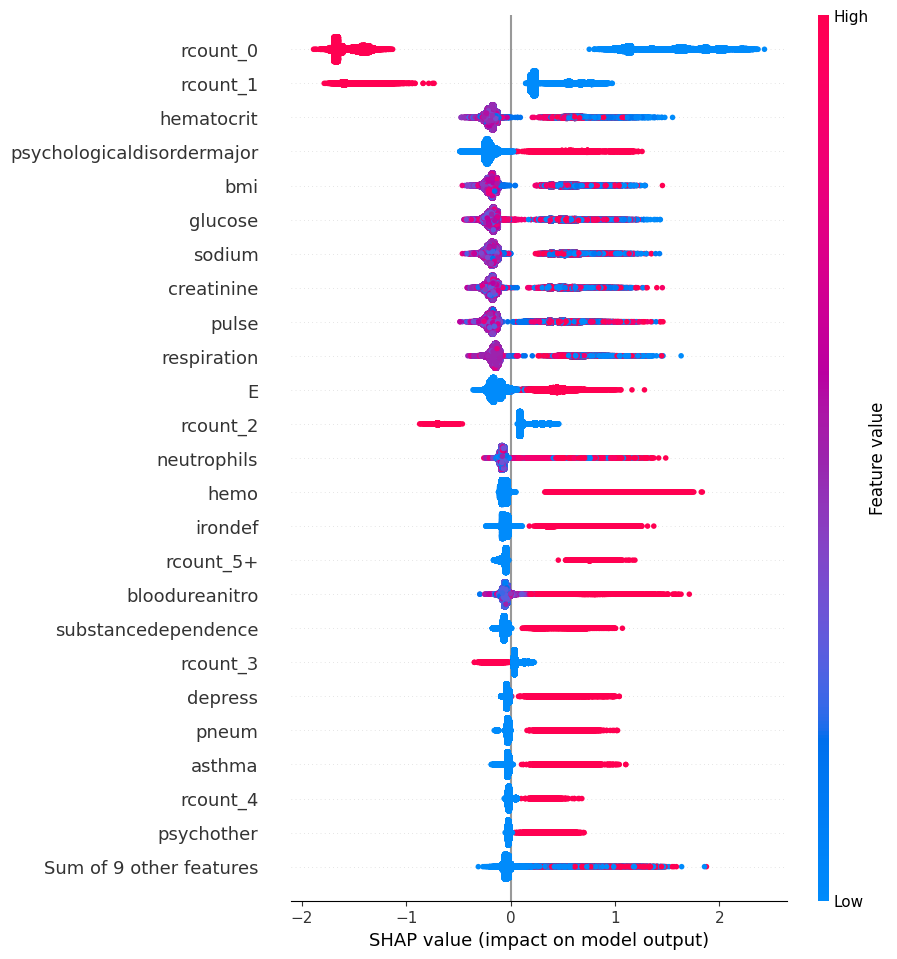

### Global: Bar

Create a bar plot.

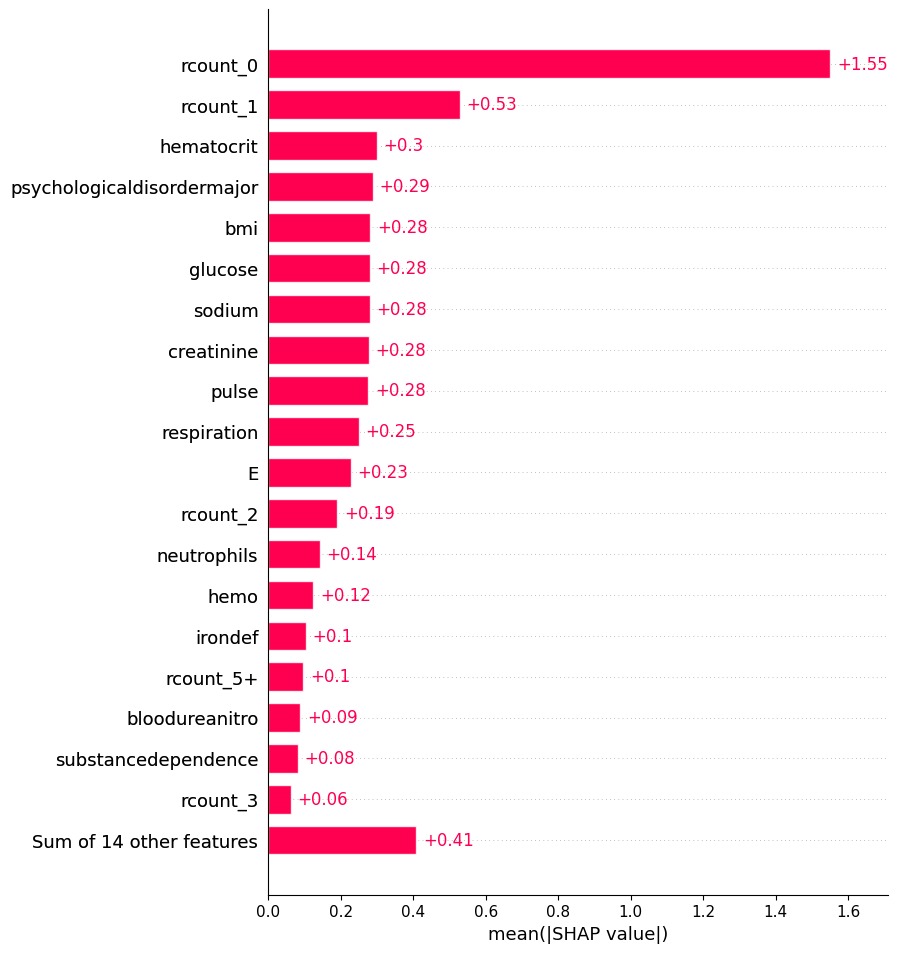

### Local: Waterfall Plots

Create a waterfall plot.

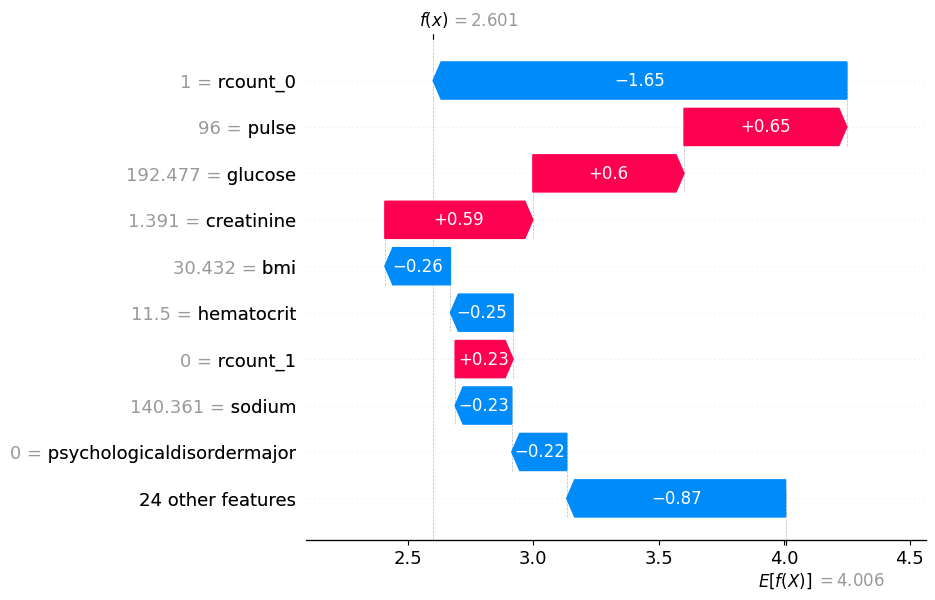

### Dependence Plots

#### Simple scatter of a single feature

Create a scatterplot of the respiration feature.

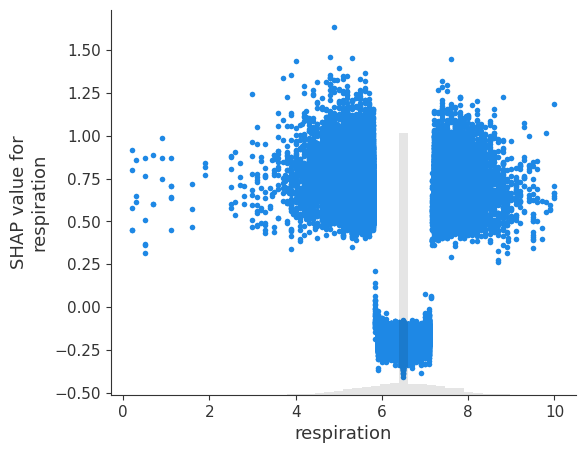

### Scatter of multiple features 

Colour the respiration plot by the most strongly interacting feature.

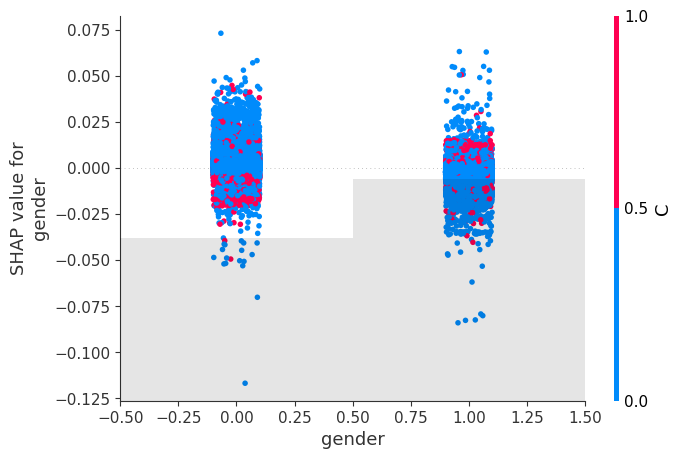

Colour the respiration plot by gender.

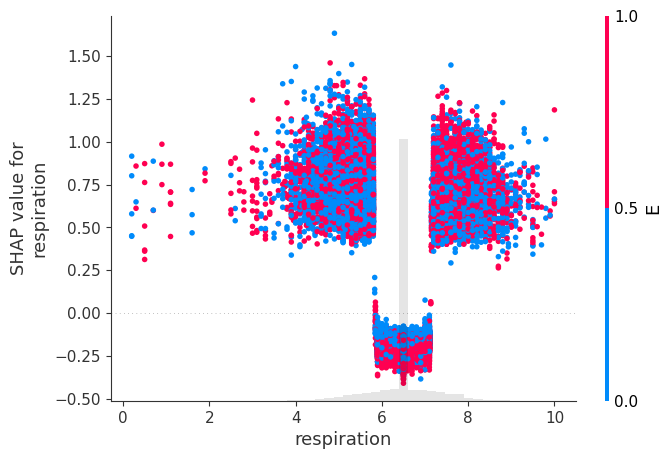

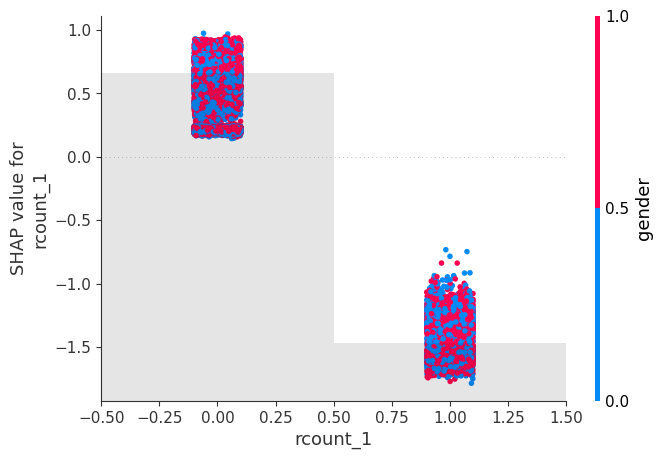